In [72]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline 

In [2]:

# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

In [3]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [5]:
# preprocessing
def remove_outliers(dta):
    # Compute the mean and interquartile range
    mean = dta.mean(0)
    iqr = dta.quantile([0.25, 0.75], axis=0).diff().T.iloc[:, 1]
    
    # Replace entries that are more than 10 times the IQR
    # away from the mean with NaN (denotes a missing entry)
    mask = np.abs(dta) > mean + 10 * iqr
    treated = dta.copy()
    treated[mask] = np.nan

    return treated

In [97]:
dta_pr = remove_outliers(log_pr.diff()).dropna() * 100

In [98]:
print(dta_pr.shape)

(263581, 10)


In [152]:
# set split date
n = 1440
split_date = dta_pr.iloc[-n:].index

In [153]:
pr_vol = dta_pr.rolling(10).std()
dta_pr_vol = pd.DataFrame(pr_vol)
dta_pr_vol.reset_index(drop=True, inplace=True)

In [119]:
returns_svm = dta_pr ** 2
returns_svm = returns_svm.reset_index()
del returns_svm['timestamp']

In [120]:
returns_svm.head()


,0,1,2,3,4,5,6,7,8,9
0,0.049931,0.020178,5.482400e-02,0.001294,0.015034,0.000002,0.010553,0.003630,0.000633,0.000764
1,0.019363,0.058996,4.111965e-03,0.000016,0.162925,0.003725,0.069708,0.008513,0.091950,0.004828
2,0.001550,0.000268,3.784388e-06,0.009785,0.003732,0.000353,0.068489,0.000019,0.004263,0.000176
3,0.005201,0.000410,5.239271e-07,0.000127,0.015599,0.001195,0.021928,0.000069,0.004621,0.000218
4,0.000424,0.002949,3.956857e-03,0.002200,0.005419,0.003395,0.016234,0.006652,0.000029,0.000462


#### Get standardised log return

In [158]:
dta_pr_std = dta_pr.iloc[9:]/(dta_pr.rolling(10).std()).iloc[9:]

In [ ]:
(dta_pr_std).iloc[-144:,0].plot(figsize=(16,6))

### Consider Stock 0 for prediction

In [121]:
dta_pr_vol_0 = dta_pr_vol[0]
X = pd.concat([dta_pr_vol_0, returns_svm[0]], axis=1, ignore_index=True)
X = X[9:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [122]:
X.shape

(263572, 2)

In [123]:
dta_pr_vol_0 = dta_pr_vol_0[9:].reset_index()
dta_pr_vol_0.drop('index', axis=1, inplace=True)

In [124]:
dta_pr_vol_0.shape

(263572, 1)

In [125]:
svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

### SVR-GARCH with linear kernel

In [126]:
para_grid = {'gamma': sp_rand(),
                'C': sp_rand(),
                'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_lin, para_grid)
clf.fit(X.iloc[:-n].values,
        dta_pr_vol_0.iloc[1:-(n-1),0].values.reshape(-1,))
predict_svr_lin = clf.predict(X.iloc[-n:])

In [127]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = dta_pr.iloc[-n:].index

In [128]:
rmse_svr = np.sqrt(mse(dta_pr_vol_0.iloc[-n:],
                                predict_svr_lin))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
    .format(rmse_svr))
# The RMSE value of SVR with Linear Kernel is 0.000462


The RMSE value of SVR with Linear Kernel is 0.017008


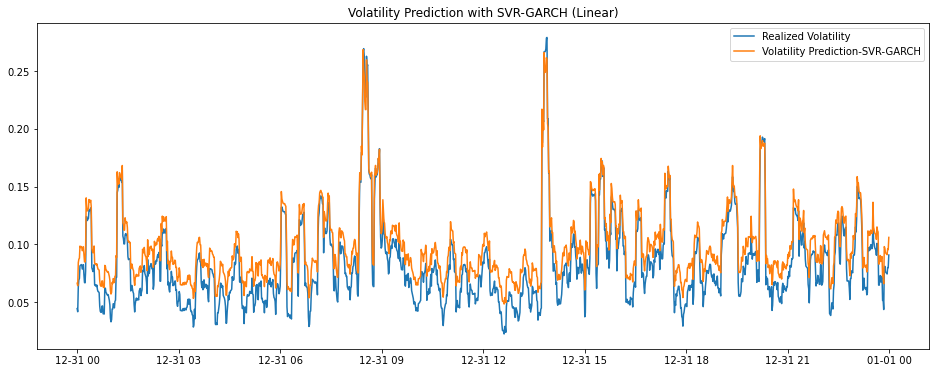

In [130]:
dta_pr_vol_0.index = dta_pr.iloc[9:].index

plt.figure(figsize=(16, 6))
plt.plot(dta_pr_vol_0.iloc[-n:], label='Realized Volatility')
plt.plot(predict_svr_lin.iloc[-n:], label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

Looks so baaaaaaad!

### SVR-GARCH with Gaussian kernel

In [131]:
para_grid = {'gamma': sp_rand(),
                'C': sp_rand(),
                'epsilon': sp_rand()}
clf_rbf = RandomizedSearchCV(svr_rbf, para_grid)
clf_rbf.fit(X.iloc[:-n].values,
        dta_pr_vol_0.iloc[1:-(n-1),0].values.reshape(-1,))

In [250]:
predict_svr_rbf = clf_rbf.predict(X.iloc[-2*n:-n])
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = dta_pr.iloc[-2*n:-n].index

In [251]:
rmse_svr = np.sqrt(mse(dta_pr_vol_0.iloc[-2*n:-n],
                                predict_svr_rbf))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
    .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.005786


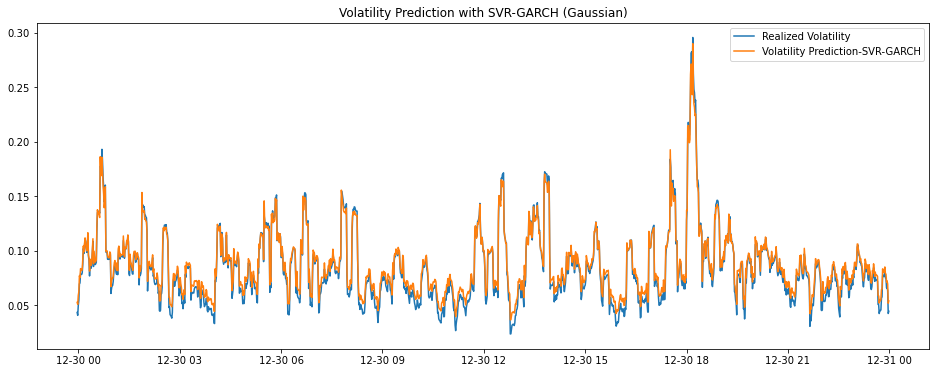

In [256]:
dta_pr_vol_0.index = dta_pr.iloc[9:].index

plt.figure(figsize=(16, 6))
plt.plot(dta_pr_vol_0.iloc[-2*n:-n], label='Realized Volatility')
plt.plot(predict_svr_rbf, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Gaussian)', fontsize=12)
plt.legend()
plt.show()

### let's try predicting dta_pr

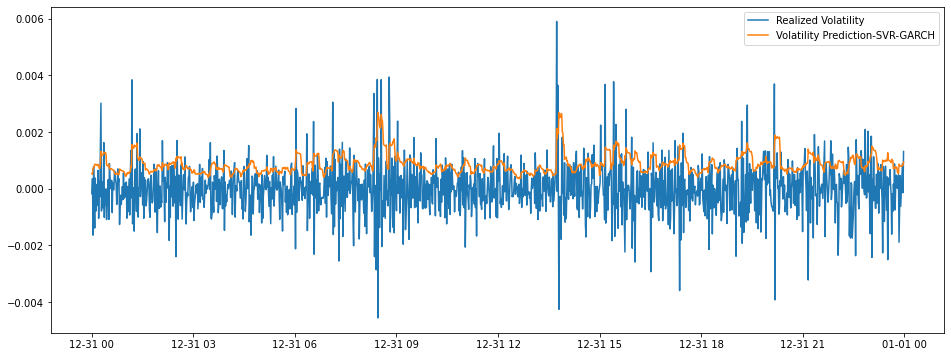

In [174]:
plt.figure(figsize=(16, 6))
plt.plot(dta_pr.iloc[-n:, 0]/100, label='Realized Volatility')
plt.plot(predict_svr_rbf.iloc[-n:]/100, label='Volatility Prediction-SVR-GARCH')
plt.legend()
plt.show()

In [163]:
dta_pr_std_0 = dta_pr_std[0]

#### Check acf and pacf plot

#### MA with Lag 2

In [314]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(dta_pr_std_0[:-n].resample('10T').sum(), order=[10,0,1], missing='drop')
res = mod.fit()

In [315]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                26351
Model:                ARIMA(10, 0, 1)   Log Likelihood              -66636.960
Date:                Sun, 10 Apr 2022   AIC                         133299.921
Time:                        22:48:09   BIC                         133406.251
Sample:                    07-01-2021   HQIC                        133334.250
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0499      0.018     -2.785      0.005      -0.085      -0.015
ar.L1         -0.0048      1.628     -0.003      0.998      -3.196       3.187
ar.L2         -0.0222      0.017     -1.287      0.198      -0.056       0.012
ar.L3         -0.0030      0.037     -0.082      0.935      -0.075       0.069
ar.L4         -0.0029      0.008     -0.361      0.718      -0.018       0.013
ar.L5         -0.0049      0.008     -0.644      0.519      -0.020       0.010
ar.L6          0.0157      0.010      1.550      0.121      -0.004       0.035
ar.L7         -0.0181      0.026     -0.690      0.490      -0.069       0.033
ar.L8         -0.0040      0.030     -0.135      0.893      -0.063       0.055
ar.L9         -0.0042      0.009     -0.466      0.641      -0.022       0.014
ar.L10         0.0037      0.009      0.406      0.685      -0.014       0.022
ma.L1         -0.0051      1.628     -0.003      0.998      -3.197       3.186
sigma2         9.2038      0.068    134.364      0.000       9.070       9.338
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               870.23
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [316]:
forecast_ar = res.forecast(steps=10)

rmse_ar = np.sqrt(mse(dta_pr_std_0.iloc[-n:-n+10],
                                forecast_ar))
print('The RMSE value of AR with Lag 2 is {:.6f}'
    .format(rmse_svr))

The RMSE value of AR with Lag 2 is 0.005786


In [323]:
rmse_0 = np.sqrt(mse(dta_pr_std_0.iloc[-n:-n+10], np.zeros(10)))
print('The RMSE value of 0 is {:.6f}'
    .format(rmse_svr))

The RMSE value of 0 is 0.005786


In [317]:
forecast_ar.index = dta_pr_std_0.iloc[-n:-n+10].index

In [318]:
forecast_ar

timestamp
2021-12-31 00:00:00   -0.025160
2021-12-31 00:01:00    0.010990
2021-12-31 00:02:00   -0.124489
2021-12-31 00:03:00   -0.070115
2021-12-31 00:04:00   -0.042514
2021-12-31 00:05:00    0.006105
2021-12-31 00:06:00   -0.050002
2021-12-31 00:07:00   -0.054725
2021-12-31 00:08:00   -0.059857
2021-12-31 00:09:00   -0.046946
Name: predicted_mean, dtype: float64

In [319]:
dta_pr_std_0.iloc[-n:-n+10]

timestamp
2021-12-31 00:00:00   -0.388093
2021-12-31 00:01:00    0.855609
2021-12-31 00:02:00   -2.598348
2021-12-31 00:03:00    1.130233
2021-12-31 00:04:00   -0.715732
2021-12-31 00:05:00   -1.702742
2021-12-31 00:06:00    0.459615
2021-12-31 00:07:00   -0.958387
2021-12-31 00:08:00   -0.686812
2021-12-31 00:09:00    0.189852
Name: 0, dtype: float64

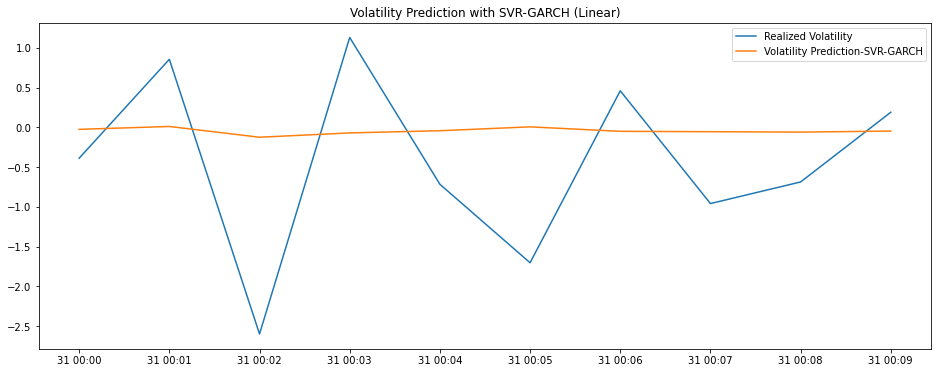

In [320]:
plt.figure(figsize=(16, 6))
plt.plot(dta_pr_std_0.iloc[-n:-n+10], label='Realized Volatility')
plt.plot(forecast_ar, label='Volatility Prediction-SVR-GARCH')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

In [277]:
predict_ar = res.predict()